In [1]:
from estimark.agents import PortfolioLifeCycleConsumerType
from estimark.parameters import init_consumer_objects, timevary_DiscFac
from HARK.utilities import plot_funcs
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
csv_file_path = "../../content/tables/Portfolio_estimate_results.csv"
res = pd.read_csv(csv_file_path, header=None)
DiscFacAdj, CRRA = res.iloc[:2, 1].astype(float).tolist()

In [3]:
portfolio_agent = PortfolioLifeCycleConsumerType(**init_consumer_objects)
portfolio_agent.CRRA = CRRA
portfolio_agent.DiscFac = [b * DiscFacAdj for b in timevary_DiscFac]
CRRA, DiscFacAdj

(5.030696061221127, 0.8981512509796122)

In [4]:
portfolio_agent.solve()

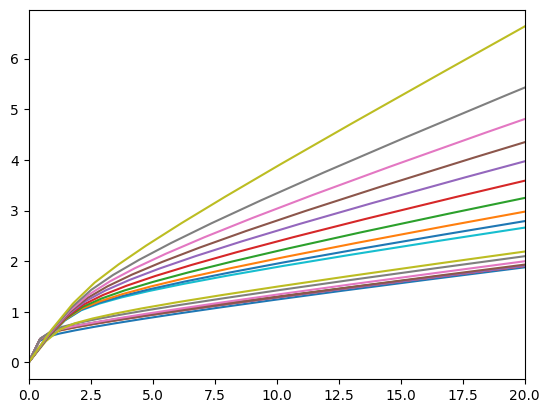

<Figure size 640x480 with 0 Axes>

In [5]:
plot_funcs([sol.cFunc for sol in portfolio_agent.solution[:-1:5]], 0, 20)
plt.savefig("../content/figures/IndShockPortfolio_cFunc.png")

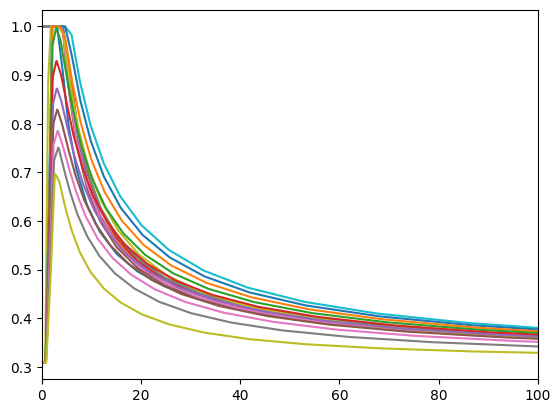

<Figure size 640x480 with 0 Axes>

In [6]:
plot_funcs([sol.ShareFuncAdj for sol in portfolio_agent.solution[:-1:5]], 0, 100)
plt.savefig("../content/figures/IndShockPortfolio_ShareFunc.png")

In [7]:
# Set up the variables we want to keep track of.
portfolio_agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm", "Share"]

portfolio_agent.T_sim = portfolio_agent.T_cycle + 1
# Run the simulations
portfolio_agent.initialize_sim()
history = portfolio_agent.simulate()

In [8]:
raw_data = {
    "Age": portfolio_agent.history["t_age"].flatten() + 25 - 1,
    "pIncome": portfolio_agent.history["pLvl"].flatten(),
    "nrmM": portfolio_agent.history["mNrm"].flatten(),
    "nrmC": portfolio_agent.history["cNrm"].flatten(),
    "Share": portfolio_agent.history["Share"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

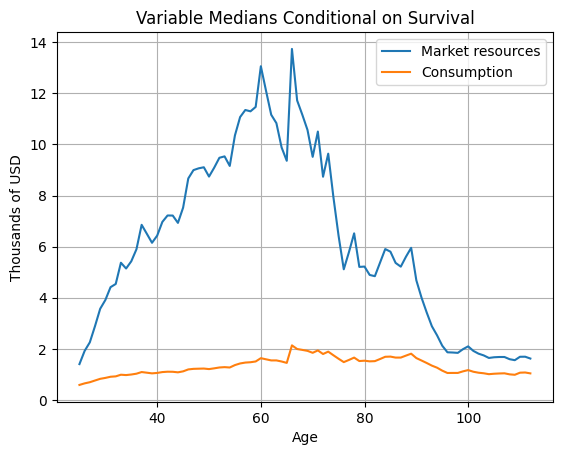

In [9]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.nrmM, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.nrmC, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()
plt.savefig("../content/figures/IndShockPortfolio_MedianVariables.png")

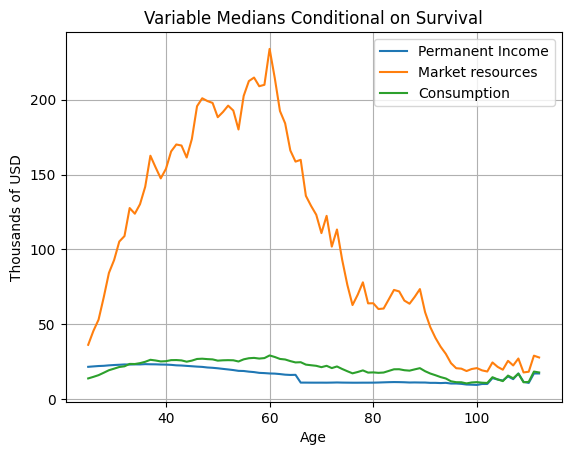

In [10]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()
plt.savefig("../content/figures/IndShockPortfolio_MedianVariables.png")

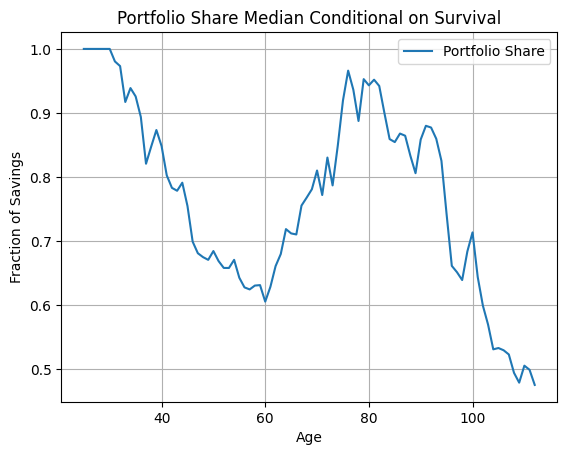

In [11]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.Share, label="Portfolio Share")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Fraction of Savings")
plt.title("Portfolio Share Median Conditional on Survival")
plt.grid()
plt.savefig("../content/figures/IndShockPortfolio_MedianShare.png")